## Preprocess Data

## Dataset

In [113]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import v2
import pandas as pd
import numpy as np
import os
from natsort import natsorted
import cv2
from matplotlib import pyplot as plt

In [168]:
class TennisDataset(Dataset):
    def __init__(self, base_path, transform, frames=1, resize=(720, 1280)):
        self.base_path = base_path
        self.frames = frames
        self.resize = resize
        self.transform = transform or v2.Compose([
            v2.Resize((resize[0], resize[1])),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True)
        ])
        # self.img_labels = []

        frames_ahead = frames // 2
        frames_behind = frames - 1 - frames_ahead

        data = []
        for game_name in natsorted(os.listdir(base_path)):
            game_path = os.path.join(base_path, game_name)
            if not os.path.isdir(game_path):
                continue

            for clip_name in natsorted(os.listdir(game_path)):
                clip_path = os.path.join(game_path, clip_name)
                if not os.path.isdir(clip_path):
                    continue

                # get labels, format their filenames, and combine them (later) into one
                label_file_path = os.path.join(clip_path, 'Label.csv')
                label = pd.read_csv(label_file_path)
                label = label[frames_behind:-frames_ahead][:]
                label = label.fillna(-1)
                label = label.rename(columns={"file name": "filename"})
                label['filename'] = game_name + '_' + clip_name + '_' + label['filename']
                data.extend(label.values.tolist())

        self.labels = pd.DataFrame(data, columns=['filename', 'visibility', 'x-coordinate', 'y-coordinate', 'status'])
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        imgs = []
        entry = self.labels.iloc[idx]
        
        filename = entry.iloc[0]
        first_sep = filename.index("_")
        second_sep = filename.index("_", first_sep + 1)
        game_name = filename[:first_sep]
        clip_name = filename[first_sep+1:second_sep]
        # img_name = filename[second_sep+1:]
        img_num = int(filename[second_sep+1:filename.index(".")])

        frames_behind = self.frames - 1 - (self.frames // 2)
        start = img_num - frames_behind
        for i in range(start, start + self.frames):
            img_name = str(i).zfill(4) + ".jpg"
            img_path = os.path.join(self.base_path, game_name, clip_name, img_name)
            img = cv2.imread(img_path)
            if self.transform:
                img = self.transform(img)
            imgs.append(img)

        imgs = np.array(imgs)
        imgs = torch.tensor(imgs)
        imgs = torch.permute(imgs, (0, 3, 1, 2))
        imgs = torch.reshape(imgs, (9, self.resize[0], self.resize[1]))

        return imgs, entry

In [153]:
a = torch.rand(3, 4, 5, 3)
# print(a)

b = torch.permute(a, (0, 3, 1, 2))
b = torch.reshape(b, (9, 4, 5))
# print(b)

In [152]:
entry = data.iloc[314]
filename = entry.iloc[0]

first_sep = filename.index("_")
second_sep = filename.index("_", first_sep + 1)

game_name = filename[:first_sep]
clip_name = filename[first_sep+1:second_sep]
# img_name = filename[second_sep+1:]
img_num = int(filename[second_sep+1:filename.index(".")])

print(f"game_name: {game_name}")
print(f"clip_name: {clip_name}")
# print(f"img_name: {img_name}")
print(f"img_num: {img_num}")

game_name: game5
clip_name: Clip4
img_num: 242


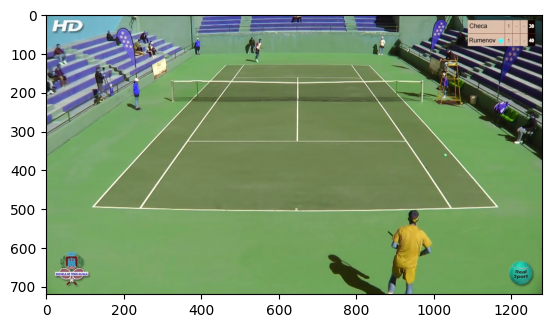

In [162]:
frames = 3
frames_behind = frames - 1 - (frames // 2)
start = img_num - frames_behind

imgs = []

for i in range(start, start + frames):
    img_name = str(i).zfill(4) + ".jpg"
    img_path = os.path.join(base_path, game_name, clip_name, img_name)
    img = cv2.imread(img_path)
    imgs.append(img)

arr = np.array(imgs)
t = torch.tensor(arr)
t = torch.permute(t, (0, 3, 1, 2))
t = torch.reshape(t, (9, 720, 1280))

img = t[:3, :, :]
# print(img.shape)
plt.imshow(img.permute(1, 2, 0))

In [87]:
data = []

temp_df = pd.read_csv('./datasets/tennis/game5/Clip3/Label.csv')
temp_ahead = 3 // 2
temp_behind = 3 - 1 - temp_ahead
temp_df = temp_df[temp_behind:-temp_ahead]
temp_df = temp_df.fillna(-1)
temp_df = temp_df.rename(columns={"file name": "filename"})

game_name = "game5"
clip_name = "Clip3"

# temp_df['filename'] = temp_df['filename'].map(lambda x: f"{game_name}_{clip_name}_{x}")
temp_df['filename'] = game_name + '_' + clip_name + '_' + temp_df['filename']

data.extend(temp_df.values.tolist())
# print(temp_df)

# data.append(temp_df)
 


temp_df = pd.read_csv('./datasets/tennis/game5/Clip4/Label.csv')
temp_ahead = 3 // 2
temp_behind = 3 - 1 - temp_ahead
temp_df = temp_df[temp_behind:-temp_ahead]
temp_df = temp_df.fillna(-1)
temp_df = temp_df.rename(columns={"file name": "filename"})

game_name = "game5"
clip_name = "Clip4"

temp_df['filename'] = game_name + '_' + clip_name + '_' + temp_df['filename']

data.extend(temp_df.values.tolist())

data = pd.DataFrame(data, columns=['filename', 'visibility', 'x-coordinate', 'y-coordinate', 'status'])

print(data.iloc[314])

print(len(data))
print(data)

filename        game5_Clip4_0242.jpg
visibility                         1
x-coordinate                  1069.0
y-coordinate                   373.0
status                           0.0
Name: 314, dtype: object
318
                 filename  visibility  x-coordinate  y-coordinate  status
0    game5_Clip3_0001.jpg           0          -1.0          -1.0    -1.0
1    game5_Clip3_0002.jpg           0          -1.0          -1.0    -1.0
2    game5_Clip3_0003.jpg           0          -1.0          -1.0    -1.0
3    game5_Clip3_0004.jpg           0          -1.0          -1.0    -1.0
4    game5_Clip3_0005.jpg           0          -1.0          -1.0    -1.0
..                    ...         ...           ...           ...     ...
313  game5_Clip4_0241.jpg           1        1033.0         365.0     0.0
314  game5_Clip4_0242.jpg           1        1069.0         373.0     0.0
315  game5_Clip4_0243.jpg           1        1113.0         385.0     0.0
316  game5_Clip4_0244.jpg           1        1

In [119]:
entry = data.iloc[314]
filename = entry.iloc[0]

first_sep = filename.index("_")
second_sep = filename.index("_", first_sep + 1)

game_name = filename[:first_sep]
clip_name = filename[first_sep+1:second_sep]
img_name = filename[second_sep+1:]
img_num = filename[second_sep+1:filename.index(".")]

print(f"game_name: {game_name}")
print(f"clip_name: {clip_name}")
print(f"img_name: {img_name}")
print(f"img_num: {img_num}")

game_name: game5
clip_name: Clip4
img_name: 0242.jpg
img_num: 0242


In [110]:
base_path = './datasets/tennis'

img_path = os.path.join(base_path, game_name, clip_name, img_name)
print(img_path)

./datasets/tennis\game5\Clip4\0242.jpg


In [117]:
img = cv2.imread(img_path)
print(type(img))
# plt.imshow(img[:, :, [2, 1, 0]])

<class 'numpy.ndarray'>


In [3]:
games_path = './datasets/tennis'

In [15]:
# print(os.path.join(games_path))
print(natsorted(os.listdir(games_path)))

['Readme.docx', 'game1', 'game2', 'game3', 'game4', 'game5', 'game6', 'game7', 'game8', 'game9', 'game10']


In [16]:
clip_path = './datasets/tennis/game5/Clip3'

In [28]:
x = natsorted(os.listdir(clip_path))
x = x[:-1]
print(x)

['0000.jpg', '0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg', '0005.jpg', '0006.jpg', '0007.jpg', '0008.jpg', '0009.jpg', '0010.jpg', '0011.jpg', '0012.jpg', '0013.jpg', '0014.jpg', '0015.jpg', '0016.jpg', '0017.jpg', '0018.jpg', '0019.jpg', '0020.jpg', '0021.jpg', '0022.jpg', '0023.jpg', '0024.jpg', '0025.jpg', '0026.jpg', '0027.jpg', '0028.jpg', '0029.jpg', '0030.jpg', '0031.jpg', '0032.jpg', '0033.jpg', '0034.jpg', '0035.jpg', '0036.jpg', '0037.jpg', '0038.jpg', '0039.jpg', '0040.jpg', '0041.jpg', '0042.jpg', '0043.jpg', '0044.jpg', '0045.jpg', '0046.jpg', '0047.jpg', '0048.jpg', '0049.jpg', '0050.jpg', '0051.jpg', '0052.jpg', '0053.jpg', '0054.jpg', '0055.jpg', '0056.jpg', '0057.jpg', '0058.jpg', '0059.jpg', '0060.jpg', '0061.jpg', '0062.jpg', '0063.jpg', '0064.jpg', '0065.jpg', '0066.jpg', '0067.jpg', '0068.jpg', '0069.jpg', '0070.jpg', '0071.jpg', '0072.jpg', '0073.jpg', '0074.jpg']
